
# Première implémentation d'un perceptron


Test sur un dataset de ScikitLearn.  
Sources utilisées :
- Documentation de ScikitLearn : https://scikit-learn.org/stable/getting_started.html
- Article : https://towardsdatascience.com/perceptron-algorithm-in-python-f3ac89d2e537
- Cours : https://www.math.univ-toulouse.fr/~besse/Wikistat/pdf/st-m-app-rn.pdf
- Codes : https://maviccprp.github.io/a-perceptron-in-just-a-few-lines-of-python-code/

__Pour commencer__  
Une première implémentation d'un perceptron pour résoudre des tâches de classification binaire avec une descente de gradient stochastique. Ce code a été directement repris depuis les sources. Le but de l'exemple qui va suivre est de comprendre comment on arrive à une telle construction du perceptron, et comment on peut l'utiliser pour résoudre un problème simple. 

In [31]:
import numpy as np

X = np.array([[-2,4,-1],[4,1,-1],[1, 6, -1],[2, 4, -1],[6, 2, -1]])

y = np.array([-1,-1,1,1,1])

def perceptron_sgd(X, Y):
    w = np.zeros(len(X[0]))
    eta = 1
    epochs = 20

    for t in range(epochs):
        for i, x in enumerate(X):
            if (np.dot(X[i], w)*Y[i]) <= 0:
                w = w + eta*X[i]*Y[i]

    return w

w = perceptron_sgd(X,y)
print(w)

[ 2.  3. 13.]


__Éléments de contexte__  
On va s'intéresser à un problème de classification binaire avec des blobs générés par ScikitLearn. Pour résoudre le problème, on utilise un perceptron avec une seule couche. Commençons par générer les données : 

Text(0.5, 1.0, 'Classification aléatoire de données avec deux classes')

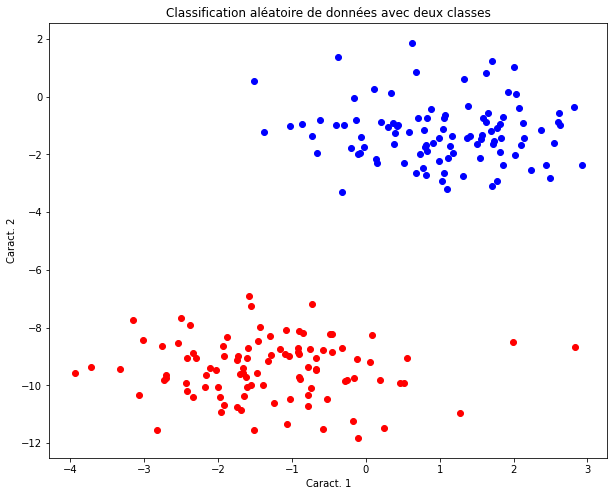

In [54]:
import matplotlib.pyplot as plt
from sklearn import datasets

# on génère un dataset de 200 points avec 2 blobs
X, y = datasets.make_blobs(n_samples=200,centers=2,n_features=2,random_state=2)

# visualisation du jeu de données
fig = plt.figure(figsize=(10,8))
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'ro')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bo')
plt.xlabel("Caract. 1")
plt.ylabel("Caract. 2")
plt.title('Classification aléatoire de données avec deux classes')

__Définition de l'objectif__  
La séparation entre les deux classes paraît claire ici. Le but va être de trouver la droite optimale qui sépare ces deux groupes en utilisant un perceptron qui va apprendre un certain nombre de paramètres.    
  
  
__Choix des caractéristiques et des paramètres__  
Comme on est dans le cas d'une classification binaire, la distribution de probabilité sur les données est une loi de Bernoulli. Il est donc préférable d'utiliser une sigmoïde pour l'output (que l'on appliquera à une couche linéaire).  
Soit $\theta$ le vecteur des paramètres. Dans l'unique étaat caché du perceptron, on va calculer $\theta^TX$. On renvoie ensuite :  
  
\begin{equation*}
h_\theta(X) = g(\theta^TX) \quad \text{où g est la fonction d'activation qui vaut 1 sur les $z$ positifs et 0 sur les $z$ strictement négatifs}
\end{equation*}  
  
__Définition de la fonction d'activation__  
Le code suivant définit la fonction ${\tt \text{step_fct}}$ qui est la fonction $g$ :

In [32]:
def step_fct(z):
    return 1.0 if (z>=0) else 0.0

__Déroulement de l'entraînement__  
La procédure décrite ci-dessous permet de faire une prédiction quant à la répartition de chacun des $X_i$ dans leurs classes $y_i$. Il nous faut maintenant pouvoir traiter le cas d'un élément mal classé, et voir comment on modifie les paramètres $\theta_i$ si on en repère un pendant la phase d'entrainement. La démarche va être très similaire à celle de la descente de gradient. Ainsi, si l'élément $X_i$ est mal classé pour un certain $i$, alors les paramètres $\theta_j$ seront modifiés tel que :
\begin{equation*}
\forall j, \enspace \theta_j = \theta_j + \alpha\left (y^{(i)} - h_\theta^{(i)} \right )X_j^{(i)}
\end{equation*}  
Où $\alpha$ est le taux d'apprentissage. Pour l'instant on n'a pas vraiment de raisons de choisir une valeur plutôt qu'une autre pour ce taux. Il est d'usage de le prendre plutôt grand lors des premiers tests puis de le baisser progressivement pour arriver à des résultats plus fins.  
  
_Remarque_ : pour l'initialisation des paramètres, on choisit de prendre tous les $\theta_i$ nuls.

In [56]:
import numpy as np

def perceptron(X, y, alpha, nb_iter):
    m,n = X.shape # m est le nombre d'exemples (200) et n le nombre de caract. pour chaque exemple (2)
    theta = np.zeros((n+1,1)) # n+1 car on rajoute un terme de biais.
    nbre_mal_classes = [0 for _ in range(nb_iter)] 
    
    # Entrainement
    for iteration in range(nb_iter):
        compte_mal_classes = 0
        
        for i, ex_i in enumerate(X):
            # ajout d'une colonne à la matrice pour le biais
            ex_i = np.insert(ex_i, 0, 1).reshape(-1,1)
            
            # calcul de la prédiction
            y_pred = step_fct(np.dot(theta.T, ex_i))
            
            # cas d'un élément mal classé
            if (np.squeeze(y_pred) - y[i]) != 0:
                theta += alpha*(y[i] - y_pred)*ex_i
                compte_mal_classes += 1
            
        nbre_mal_classes[iteration] = compte_mal_classes
    
    return(theta, nbre_mal_classes)

perceptron(X, y, 0.0001, 10)

(array([[0.0017    ],
        [0.00053555],
        [0.00041869]]),
 [22, 5, 0, 0, 0, 0, 0, 0, 0, 0])

## Représentation graphique du résultat

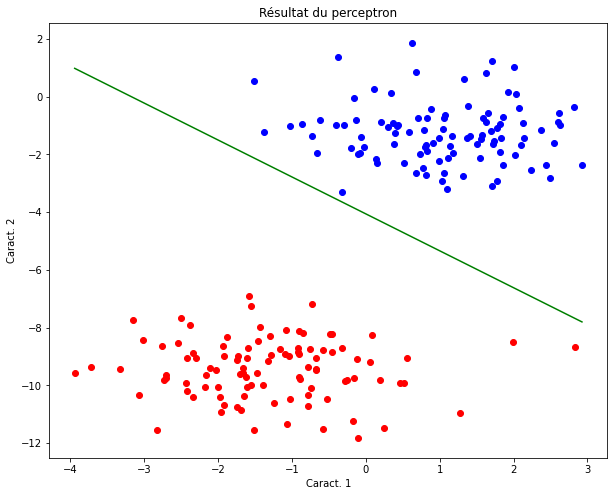

In [57]:
def trace_separation(X, theta):
    # on trace la droite d'equation ax + b =theta0*X0 + theta1*X1 + theta2*X2
    x1 = [min(X[:,0]), max(X[:,0])]
    a = -theta[1]/theta[2]
    b = -theta[0]/theta[2]
    x2 = a*x1 + b
    
    # tracé des points et de la droite
    fig = plt.figure(figsize=(10,8))
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo")
    plt.xlabel("Caract. 1")
    plt.ylabel("Caract. 2")
    plt.title("Résultat du perceptron")
    plt.plot(x1, x2, 'g')

theta, n = perceptron(X, y, 0.05,100)
trace_separation(X, theta)

__Remarques + ouverture__  
Je n'ai pas l'impression que changer le taux d'apprentissage dans cet exemple change quelque chose, est-ce normal ? De plus, changer le nombre d'itérations ne change en général pas grand chose mais cela est normal car le nombre de points mal placés tombe à 0 après seulement 5 itérations (le modèle est performant !)